In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conference =  pd.read_csv('conference.csv')
game_statistics = pd.read_csv('game-statistics.csv')
drive = pd.read_csv('drive.csv')
game = pd.read_csv('game.csv')
kickoff_return = pd.read_csv('kickoff-return.csv')
kickoff = pd.read_csv('kickoff.csv')
ppass = pd.read_csv('pass.csv')
play = pd.read_csv('play.csv')
player_game_statistics = pd.read_csv('player-game-statistics.csv')
player = pd.read_csv('player.csv')
punt_return = pd.read_csv('punt-return.csv')
punt = pd.read_csv('punt.csv')
reception = pd.read_csv('reception.csv')
rush = pd.read_csv('rush.csv')
stadium = pd.read_csv('stadium.csv')
team_game_statistics = pd.read_csv('team-game-statistics.csv')
team = pd.read_csv('team.csv')

In [3]:
#conference_teams = conference_teams.rename(columns = {'Name_x':'Team','Name_y':'Conference'})

'''The dataframe about each play in college football does not contain the date of the game. In order to get the plays seperated
into their appropriate month, I merge the data that does contain this information. I then take the first 2 positions of the
date, seperating by month
'''
frame = pd.merge(play, game, on= 'Game Code')
september_game_codes = frame[frame.Date.str[:2] == '09']['Game Code'].unique()
october_game_codes = frame[frame.Date.str[:2] == '10']['Game Code'].unique()
november_game_codes = frame[frame.Date.str[:2] == '11']['Game Code'].unique()
december_game_codes = frame[frame.Date.str[:2] == '12']['Game Code'].unique()

'''We also need to seperate out the running backs first, and then further seperate out by class standing
'''
rb = player[player.Position == 'RB']
rb_fr = rb[rb.Class == 'FR']['Player Code']
rb_so = rb[rb.Class == 'SO']['Player Code']
rb_jr = rb[rb.Class == 'JR']['Player Code']
rb_sr = rb[rb.Class == 'SR']['Player Code']

merged_team_conference = pd.merge(team, team_game_statistics, on= 'Team Code')



Q 2: In the 4th quarter, is there a linear relationship between how many points a team is down compared to the number of pass plays that the team runs when they are on offense. I believe a team down by a lot would run a more risky offense (more passes). In addition, at what point do we see a point differential as “insurmountable”, and the offense stops running a pass offense. These would show up as outliers.

In [5]:
'''The first thing to do here is to filter the all of the plays to only find the plays that happened in the 4th quarter and
plays in which the team on offense was losing. 
'''
diff = play[(play['Period Number'] == 4) & (play['Offense Points'] < play['Defense Points'])].dropna(subset = ['Drive Number'])
diff[diff['Play Type'] == 'RUSH']['Game Code'].count() #5220 Rush plays when losing
diff[diff['Play Type'] == 'PASS']['Game Code'].count() #8206 Pass plays when losing

8206

In [6]:
'''Because there is no data in the data set that says "This is the pass rate for a team by each quarter", I had to make 
that information for myself. In order to do this, I need to iterate through many different data frames. First, I create
a dictionary, where the key in the dictionary is the unique game code to each game. The value to this key is a list
of drive numbers in the fourth quater.
'''
game_drive_dictionary = {}
for game in diff['Game Code'].unique().tolist():
    game_drive_dictionary[game] = diff[(diff['Game Code'] == game)]['Drive Number'].unique().tolist()

first_look = pd.DataFrame(columns = ['point_difference','pass_ratio'])

''' Now that the key-value pairs are set, we can iterate through the keys, and then throughthe value list. When the
Game Code and Drive number are set, we can ask about what each of the plays in that drive consist of. Just like with the
fumble rate in the first question, we can ask to give a count of the total pass plays against the total number of plays in
the drive, giving us the pass ratio for the drive. We append this pass rate to a data frame, first_look, along with the
total points that the losing team is down by.
'''
for game in game_drive_dictionary:
    for drive in game_drive_dictionary[game]:
        specific_drive= diff[(diff['Game Code'] == game) & (diff['Drive Number'] == drive)]
        
        pass_play = specific_drive[specific_drive['Play Type'] == 'PASS']['Play Number'].count()
        plays = specific_drive['Play Number'].count()
        score_diff = specific_drive['Defense Points'].unique().tolist()[0] - specific_drive['Offense Points'].unique().tolist()[0]
        first_look  = first_look .append({'pass_ratio':pass_play/plays,'point_difference':score_diff}, ignore_index = True)
        

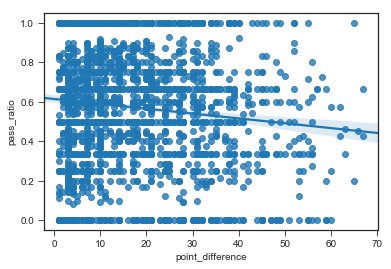

-0.1086055293395177

In [24]:
plt.show(sns.regplot(x = 'point_difference',y='pass_ratio',data = first_look))
first_look['point_difference'].corr(first_look['pass_ratio'])

From this graph, there appear to be 6 very clear columns: 0.0, 0.3, 0.5, ~0.65, ~0.75, and 1.0. Lets find out the exact values and then further look into what ratios actually are and what count each of these constitute for the total drives of the season
{1.0, 0.6667, 0.5, 0.0, 0.333, 0.75}


In [8]:
'''This dataframe just gives me an idea on what the most common pass ratios were when a team was losing in the fourth quarter
'''
first_look.groupby('pass_ratio').count().sort_values('point_difference', ascending = False).head(6)

,point_difference
pass_ratio,
1.000000,397
0.666667,279
0.500000,256
0.000000,208
0.333333,181
0.750000,134


Further things to look at: How does this change if the difference is less than 14, above 35
How does time affect 

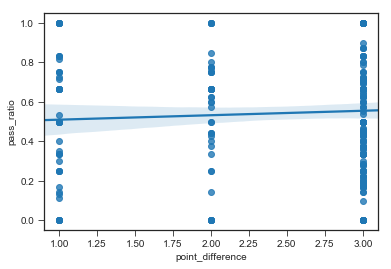

In [9]:
'''When I didn't see anything in the total data that lookied correlational, I decided to try different filters depending
on how many points a team dwas down by. Here, we can see what happens when a team is down by 3 or fewer points. 
'''
low_filtered_first_look = first_look[first_look['point_difference'] <= 3]
plt.show(sns.regplot(x = 'point_difference',y='pass_ratio',data = low_filtered_first_look))

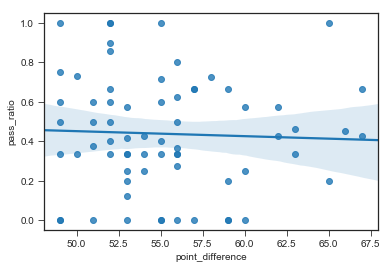

In [10]:
'''Down by 49 or more points
'''
high_filtered_first_look = first_look[first_look['point_difference'] >= 49]
plt.show(sns.regplot(x = 'point_difference',y='pass_ratio',data = high_filtered_first_look))

In [12]:
#specific_drive= diff[(diff['Game Code'] == 5004720051105) & (diff['Drive Number'] == 19.0)]

In [13]:
#specific_drive.dropna(subset = ['Clock'])['Clock'].tolist()[0]/60

12.783333333333333

In [14]:
'''I wasn't finding anything that was of interest by the previous setup. And while I know Dr. Teplovs said that sometimes
nothing of interest is a finding, I knew that there could be more information somewhere in here, as long as I look hard enough. 
In order to see if there was some correlated values, I decided to add another dimension to the data: time left. 
To do this, I created another new dataframe, with the same information from before, but added the time left, and divided by 60, 
just to have minutes left instead of seconds left. 
'''
second_look = pd.DataFrame(columns = ['point_difference','pass_ratio','time_remaining'])
    
for game in game_drive_dictionary:
    for drive in game_drive_dictionary[game]:
        specific_drive= diff[(diff['Game Code'] == game) & (diff['Drive Number'] == drive)]
        
        pass_play = specific_drive[specific_drive['Play Type'] == 'PASS']['Play Number'].count()
        plays = specific_drive['Play Number'].count()
        score_diff = specific_drive['Defense Points'].unique().tolist()[0] - specific_drive['Offense Points'].unique().tolist()[0]
        specific_drive.dropna(subset = ['Clock'])
        time = specific_drive.dropna(subset = ['Clock'])['Clock'].tolist()[0]/60
        second_look  = second_look .append({'pass_ratio':pass_play/plays,'point_difference':score_diff, 'time_remaining':time}, ignore_index = True)

In [15]:
second_look.head()

,point_difference,pass_ratio,time_remaining
0,33.0,0.333333,14.916667
1,40.0,1.000000,8.166667
2,47.0,0.666667,5.400000
3,40.0,1.000000,3.166667
4,47.0,0.000000,0.600000


In [16]:
'''Just to make it easy on myself, I seperate out the dataframes immedietely, and then can manipulate subsections of the data
frame depeninding on point differentials
'''
second_look_zero_to_five = second_look[second_look['time_remaining'] < 5]
second_look_five_to_ten = second_look[(second_look.time_remaining >= 5) & (second_look.time_remaining < 10)]
second_look_ten_to_fifteen = second_look[(second_look.time_remaining >= 10)]

In [17]:
second_look_zero_to_five.head()

,point_difference,pass_ratio,time_remaining
3,40.0,1.00,3.166667
4,47.0,0.00,0.600000
7,2.0,0.75,0.850000
13,17.0,0.25,4.333333
16,12.0,1.00,3.633333


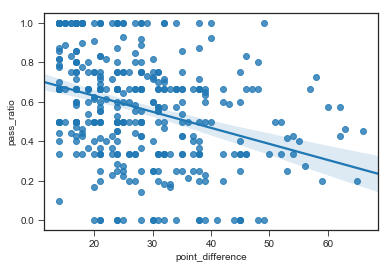

-0.3348191993089179

In [35]:
'''Down by more than 14 points with 5-10 minutes left ended up being the only real subset of data that showed anything
that would be applicable to calling correlated, despite being a low moderate correlation of -0.335
'''
plt.show(sns.regplot(x = 'point_difference',y='pass_ratio',data = second_look_five_to_ten[second_look_five_to_ten['point_difference'] >= 14]))
df = second_look_five_to_ten[(second_look_five_to_ten['point_difference'] >= 14)]
df['point_difference'].corr(df['pass_ratio'])

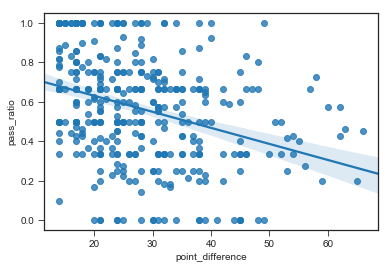

-0.26763938630001416

In [33]:
plt.show(sns.regplot(x = 'point_difference',y='pass_ratio',data = second_look_five_to_ten[second_look_five_to_ten['point_difference'] >= 14]))
df = second_look_five_to_ten[(second_look_five_to_ten['point_difference'] >= 14) & (second_look_five_to_ten['point_difference'] <= 28)]
df['point_difference'].corr(df['pass_ratio'])

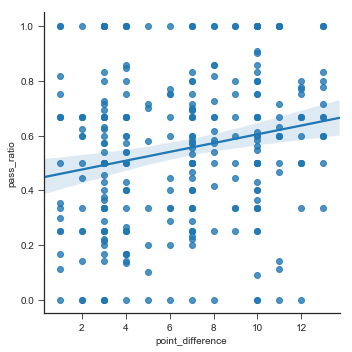

0.20629337575825213

In [19]:
#Down by less than 14 with less with 5-10 minutes
plt.show(sns.lmplot(x = 'point_difference',y='pass_ratio',data = second_look_five_to_ten[second_look_five_to_ten['point_difference'] < 14]))
df = second_look_five_to_ten[second_look_five_to_ten['point_difference'] < 14]
df['point_difference'].corr(df['pass_ratio'])

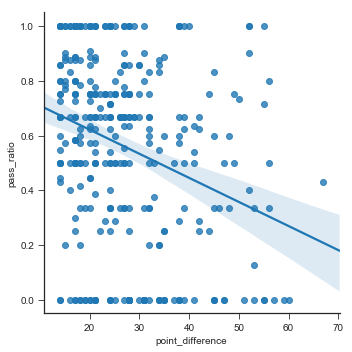

-0.28626116875838342

In [20]:
#Down by 14 or more with less with 0-5 minutes
plt.show(sns.lmplot(x = 'point_difference',y='pass_ratio',data = second_look_zero_to_five[second_look_zero_to_five['point_difference'] >= 14]))
df = second_look_zero_to_five[second_look_zero_to_five['point_difference'] >= 14]
df['point_difference'].corr(df['pass_ratio'])

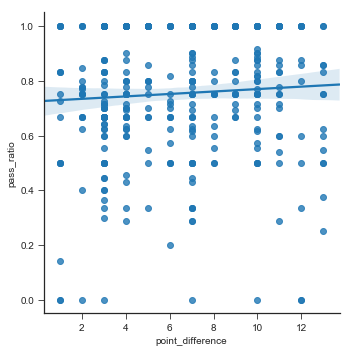

0.065639879205696111

In [21]:
#Down by 14 or more with less with 0-5 minutes
plt.show(sns.lmplot(x = 'point_difference',y='pass_ratio',data = second_look_zero_to_five[second_look_zero_to_five['point_difference'] < 14]))
df = second_look_zero_to_five[second_look_zero_to_five['point_difference'] < 14]
df['point_difference'].corr(df['pass_ratio'])

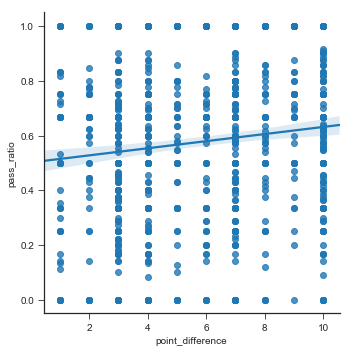

0.12362016794144175

In [22]:
low_filtered_second_look = second_look[second_look['point_difference'] <= 10]
plt.show(sns.lmplot(x = 'point_difference',y='pass_ratio',data = low_filtered_second_look ))
low_filtered_second_look['point_difference'].corr(low_filtered_second_look['pass_ratio'])

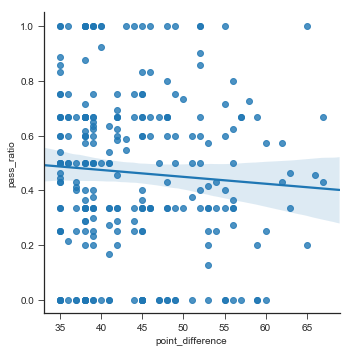

-0.067215176679323141

In [23]:
high_filtered_second_look = second_look[second_look['point_difference'] >=35]
plt.show(sns.lmplot(x = 'point_difference',y='pass_ratio',data = high_filtered_second_look ))
high_filtered_second_look['point_difference'].corr(high_filtered_second_look['pass_ratio'])